<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Linear Regression

_Authors: Kevin Markham (Washington, D.C.), Ed Podojil (New York City), Bryce Peake (Washington, D.C.), Steven Longstreet (Washington, D.C.)_

#### Learning Objectives
- Define data modeling and simple linear regression.
- Build a linear regression model using a data set that meets the linearity assumption using the scikit-learn library.
- Understand and identify multicollinearity in a multiple regression.

### Lesson Guide

- [Linear Regression Basics](#linear-regression-basics)
	- [Form of Linear Regression](#form-of-linear-regression)
- [Overview of Supervised Learning](#overview-of-supervised-learning)
	- [Benefits and Drawbacks of scikit-learn](#benefits-and-drawbacks-of-scikit-learn)
	- [Requirements for Working With Data in scikit-learn](#requirements-for-working-with-data-in-scikit-learn)
	- [Building a Linear Regression Model in sklearn](#building-a-linear-regression-model-in-sklearn)
	- [scikit-learn's Four-Step Modeling Pattern](#scikit-learns--step-modeling-pattern)
- [Build a Linear Regression Model](#build-a-linear-regression-model)
- [Using the Model for Prediction](#using-the-model-for-prediction)
	- [Does the Scale of the Features Matter?](#does-the-scale-of-the-features-matter)
- [Work With Multiple Features](#work-with-multiple-features)
	- [Visualizing the Data (Part 2)](#visualizing-the-data-part-)
	- [Adding More Features to the Model](#adding-more-features-to-the-model)
- [What Is Multicollinearity?](#what-is-multicollinearity)
- [How to Select a Model](#how-to-select-a-model)
	- [Feature Selection](#feature-selection)
	- [Evaluation Metrics for Regression Problems](#evaluation-metrics-for-regression-problems)
	- [Comparing Models With Train/Test Split and RMSE](#comparing-models-with-traintest-split-and-rmse)
	- [Comparing Testing RMSE With Null RMSE](#comparing-testing-rmse-with-null-rmse)
- [Feature Engineering to Improve Performance](#feature-engineering-to-improve-performance)
	- [Handling Categorical Features](#handling-categorical-features)
	- [Feature Engineering](#feature-engineering)
- [Bonus Material: Regularization](#bonus-material-regularization)
	- [How Does Regularization Work?](#how-does-regularization-work)
	- [Lasso and Ridge Path Diagrams](#lasso-and-ridge-path-diagrams)
	- [Advice for Applying Regularization](#advice-for-applying-regularization)
	- [Ridge Regression](#ridge-regression)
- [Comparing Linear Regression With Other Models](#comparing-linear-regression-with-other-models)

## What is Data Modeling?

A Data Model for a data scientist is an artifact created by the machine learning process one might even consider a program in its own right. The model will accept data and return the appropriate output. 

The overall process is fairly linear and is the end result of our Data Science process. Our goal is to:

1. Create a Hypothesis or a question we want to test/explore

2. Load, clean and transform relevant data

3. Identify relevant features for both the question and the model

4. Build a process with an appropriate machine learning algorithm or statistical methodology that suits your data, use case, and available computational resources

5. Test, evaluate and refine your model. Often Data Scientists create numerous models until aligning on the one creating the best output

6. Deploy the model - This can be accomplished through batch processing or moved into a real time production environment

7. Monitor and refine the model over time


The end result is a clear and defined process to accept raw information and create predictive or prosciptive insights to your organization

<a id="introduce-the-bikeshare-dataset"></a>
## Introduce the Bikeshare Data Set
---

We'll be working with a data set from Capital Bikeshare that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)).

The objective of the competition is to predict total ridership of Capital Bikeshare in any given hour.

Demand forecasting is a common data science application. If we can predict the quantity of demand, total ridership in a given hour, we can create analytical tools to improve the bikeshare system. 
Some applications would be:
* Find where to site new bikeshare stations and know how large of a station to build.
* Calculate the expected wear and tear on bikes and what the replacement costs will be.
* Use a slightly different research design to forecast full and empty stations and send a service vehicle to "rebalance" the bikes from one station to another, as sometimes bikeshare stations have no bikes or are completely full and prevent use of the station.

Businesses aren't new to demand forecasting, but older methods suffered from poor predictions at atypical small locations. Modern approaches incorporate clusters and online data from Twitter and Google Trends to improve prediction in these small locations.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

<a id="read-in-the--capital-bikeshare-data"></a>
### Read In the Capital Bikeshare Data

In [4]:
# Read the data and set the datetime as the index.
ata = './data/bikeshare.csv'
bikes = pd.read_csv(data)


Notice that we used `index_col` to set an index or primary key for our data. In this case, the index of each row will be set to the value of its `datetime` field.

We also ask Pandas to parse dates (if `parse_dates=True`, for the index only). So, rather than reading in a string, Pandas converts the index string to a `datetime` object.

In [2]:
#create a datetime object using pandas, then apply the day_name() method
bikes['datetime'] = pd.to_datetime(bikes.datetime)
bikes['day-of-week'] = bikes['datetime'].dt.day_name()

# Preview the first five rows of the DataFrame.
bikes.head()

NameError: name 'bikes' is not defined

#### What does each observation represent?

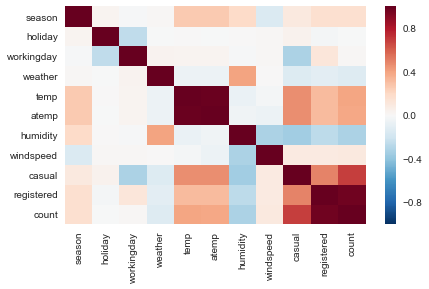

In [4]:
# A:
sns.heatmap(bikes.corr())

#### What is the response variable?

In [5]:
# A:

#### How many features are there?

In [6]:
# A:
len(bikes.columns)

11

| Variable| Description |
|---------|----------------|
|datetime| hourly date + timestamp  |
|season|  1=winter, 2=spring, 3=summer, 4=fall |
|holiday| whether the day is considered a holiday|
|workingday| whether the day is neither a weekend nor holiday|
|weather| See Below|
|temp| temperature in Celsius|
|atemp| "feels like" temperature in Celsius|
|humidity| relative humidity|
|windspeed| wind speed|
|casual| number of non-registered user rentals initiated|
|registered| number of registered user rentals initiated|
|count| number of total rentals|

> _Details on Weather Variable_

> **1**: Clear, Few clouds, Partly cloudy, Partly cloudy

> **2**: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

> **3**: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

> **4**: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

#### "count" is a method in Pandas (and a very non-specific name), so it's best to name that column something else

In general, you may want to rename columns if it is not obvious what might be stored in them. Although we will only rename the target column here, a few examples might be to rename:

| old name | new name |
| ---    | --- |
| temp | temp_celcius
| windspeed | windspeed_knots
| casual | num_casual_users
| registered | num_registered_users
| season | season_num
| holiday | is_holiday
| workingday | is_workingday
| humidity | humidity_percent

Without having to check, these new names make it obvious what is stored in each column. The downside is slightly longer column names, which could affect table readability in Jupyter. It would be ideal to use very specific names in CSV files to assist others reading them. In your own code, use whatever makes sense for your work -- if you are viewing lots of Pandas tables, you may want to use shorter names. However, readable specific names are preferred in Python code since it prevents mistakes.

In [8]:
# Use the .rename() method to rename count to total
bikes.rename(columns={'count':'total_rentals'}, inplace=True) 

<a id="visualizing-the-data"></a>
### Visualizing the Data

It is important to have a general feeling for what the data looks like before building a model. Ideally, before creating the model you would have some sense of which variables might matter most to predict the response. This dataset is fairly intuitive (and the purpose of this lesson is not visualization), so we will keep the visualization short.

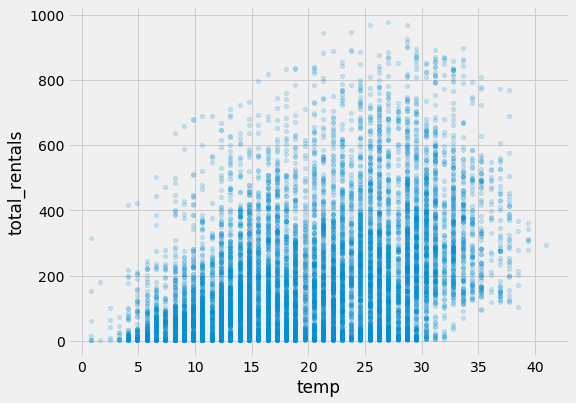

In [9]:
# Pandas scatterplot
bikes.plot(kind='scatter', x='temp', y='total_rentals', alpha=0.2);

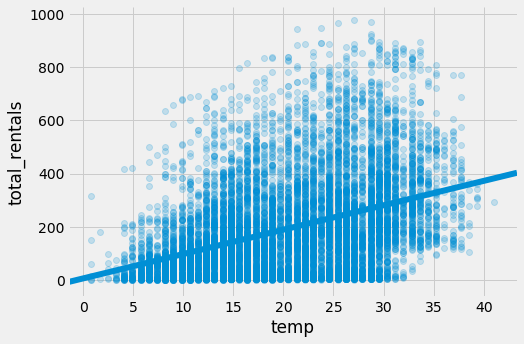

In [10]:
# Seaborn scatterplot with regression line
sns.lmplot(x='temp', y='total_rentals', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2});

<a id="linear-regression-basics"></a>
## Linear Regression Basics
---

### When it works best

Data is normally distributed (but doesn't have to be)
X's significantly explain y (low p-values)
X's are independent of each other (little to no multicollinearity)
Resulting values pass a linear assumption 

The regression has six key assumptions:

1. Linear relationship between target and features
2. Data is normally distributed or contains Multivariate normality (but doesn't have to be)
3. No or little multicollinearity
4. No auto-correlation
5. Homoscedasticity
6. Independent features

Note: If data is not normally distributed, we could be introducing bias

**1. Linear Relationship** 

First, linear regression needs the relationship between the independent and dependent variables to be linear.  It is also important to check for outliers since linear regression is sensitive to outlier effects.  The linearity assumption can best be tested with scatter plots

**2. Normal Distribution**

Since the linear regression analysis requires all variables to be multivariate normal it can be checked with a histogram or Q-Q plot. Normality can also be checked with a goodness of fit test like the [Kolmogorov-Smirnov] test(https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html) . When the data is not normally distributed it's possible a non-linear transformation (e.g., log-transformation) might fix this issue.

**3. Low to No Multicollinearity**

Multicollinearity occurs when the independent variables are too highly correlated with each other. A quick way to test this is our tried and true correlation matrix. 

If multicollinearity is found in the data centering the data, that is deducting the mean score might help to solve the problem.  Other alternatives to tackle the problems is conducting a factor analysis and rotating the factors to insure independence of the factors in the linear regression analysis.

**4. Low to No Auto-correlation**

Linear regression analysis requires that there is little or no autocorrelation in the data.  Autocorrelation occurs when the residuals are not independent from each other.  In other words when the value of y(x+1) is not independent from the value of y(x). Examples are signal processing or time series data

While a scatterplot allows you to check for autocorrelations, you can test the linear regression model for autocorrelation with the [Durbin-Watson test](http://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.durbin_watson.html).  Durbin-Watson’s d tests the null hypothesis that the residuals are not linearly auto-correlated.  While d can assume values between 0 and 4, values around 2 indicate no autocorrelation.  As a rule of thumb values of 1.5 < d < 2.5 show that there is no auto-correlation in the data. However, the Durbin-Watson test only analyses linear autocorrelation and only between direct neighbors, which are first order effects.


**5. Homoscedastic data **

Homoscedastic data means the residuals are equal across the regression line. We can test this with scatterplots or seaborne's lmplot()

**6. Independent features**

Independent features are in no way derived from other featuress. Imagine a dataset composed of three features. The first two features are in no way related but the third feature is simply the sum of the first two. That means this ficitonal dataset has one linearly dependent feature. That’s a problem for linear regression since we expect to interpret our outputs as X increase in feature A drives an increase of Y units of the response variable. However, if features are correlated, you lose the ability to interpret the linear regression model because you violate a fundamental assumption.



<a id="form-of-linear-regression"></a>
### Form of Linear Regression

Recall that each model always contains some amount of random irreducible error $\epsilon$. So, given a prediction $\hat{y}$, the actual $y = \hat{y} + \epsilon$. Below, we will assume $y$ is exactly linear.

- We are often taught the formula for a line is: $y = mx + b$.
- Note this can alternatively be written: $y = \alpha + \beta X$.

---

Here, we will generalize this to $n$ independent variables as follows:

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon$

- $y$ is the response.
- $\beta_0$ is the intercept.
- $\beta_1$ is the coefficient for $x_1$ (the first feature).
- $\beta_n$ is the coefficient for $x_n$ (the nth feature).
- $\epsilon$ is the _error_ term

A practical example of this applied to our data might be:

$total\_rides = 20 + -2 \cdot temp + -3 \cdot windspeed\ +\ ...\ +\ 0.1 \cdot registered$

This equation is still called **linear** because the highest degree of the independent variables (e.g. $x_i$) is 1. Note that because the $\beta$ values are constants, they will not be independent variables in the final model, as seen above.

---

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we are trying to find the line (mathematically) that minimizes the **sum of squared residuals** (or "sum of squared errors").
- Once we've learned these coefficients, we can use the model to predict the response.

![Estimating coefficients](./assets/estimating_coefficients.png)

In the diagram above:

- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the vertical distances between the observed values and the least squares line.

<a id="overview-of-supervised-learning"></a>
## Overview of Supervised Learning
---

![Supervised learning diagram](./assets/supervised_learning.png)

<a id="benefits-and-drawbacks-of-scikit-learn"></a>
### Benefits and Drawbacks of scikit-learn

**Benefits:**

- Consistent interface to machine learning models.
- Provides many tuning parameters but with sensible defaults.
- Exceptional documentation.
- Rich set of functionality for companion tasks.
- Active community for development and support.

**Potential drawbacks:**

- Harder (than R) to get started with machine learning.
- Less emphasis (than R) on model interpretability.
    - scikit-learn tends not to run detailed statistical tests, e.g. ANOVA.
    - For more detail on model fit, try the `statsmodels` library.

Ben Lorica: [Six Reasons Why I Recommend scikit-learn](http://radar.oreilly.com/2013/12/six-reasons-why-i-recommend-scikit-learn.html)

<a id="requirements-for-working-with-data-in-scikit-learn"></a>
### Requirements for Working With Data in scikit-learn

1. Features and response should be separate objects.
2. Features and response should be entirely numeric.
3. Features and response should be NumPy arrays (or easily converted to NumPy arrays).
4. Features and response should have specific shapes (outlined below).

<a id="building-a-linear-regression-model-in-sklearn"></a>
### Building a Linear Regression Model in sklearn

#### Create a feature matrix called X that holds a `DataFrame` with only the temp variable and a `Series` called y that has the "total_rentals" column.

In [11]:
# Create X and y.
feature_cols = ['temp']
X = bikes[feature_cols]
y = bikes.total_rentals

In [12]:
# Check X's type.
print((type(X)))
print((type(X.values)))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [12]:
# Check y's type.
print((type(y)))
print((type(y.values)))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [13]:
# Check X's shape (n = number of observations, p = number of features).
print((X.shape))

(10886, 1)


In [14]:
# Check y's shape (single dimension with length n).
# The comma indicates the datatype is a tuple.
print((y.shape))

(10886,)


<a id="scikit-learns--step-modeling-pattern"></a>
### scikit-learn's Four-Step Modeling Pattern

**Step 1:** Import the class you plan to use.

In [14]:
from sklearn.linear_model import LinearRegression

**Step 2:** "Instantiate" the "estimator."

- "Estimator" is scikit-learn's term for "model."
- "Instantiate" means "make an instance of."

In [15]:
# Make an instance of a LinearRegression object.
lr = LinearRegression()
type(lr)

sklearn.linear_model.base.LinearRegression

- Created an object that "knows" how to do linear regression, and is just waiting for data.
- Name of the object does not matter.
- All parameters not specified are set to their defaults.
- Can specify tuning parameters (aka "hyperparameters") during this step. 

To view the possible parameters, either use the `help` built-in function or evaluate the newly instantiated model, as follows:

In [16]:
# help(lr)
lr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

**Step 3:** Fit the model with data (aka "model training").

- Model is "learning" the relationship between X and y in our "training data."
- Process through which learning occurs varies by model.
- Occurs in-place.

In [17]:
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
dict(zip(lr.coef_,X.columns))

{9.170540481426238: 'temp'}

- Once a model has been fit with data, it's called a "fitted model."

**Step 4:** Predict the response for a new observation.

- New observations are called "out-of-sample" data.
- Uses the information it learned during the model training process.

In [20]:
# Per future warning, one-dimensional arrays must be reshaped using the following.
lr.predict(np.array([0]).reshape(1,-1))

array([ 6.04621296])

Let's ask the model to make two predictions, one when the `temp` is 0 and another when the `temp` is 10. To do this, our feature matrix is always a 2-D array where each row is a list of features. Since we only have a single feature, the temperature, each row will contain only a single value.

In [21]:
X_new = [[0], [10]]
lr.predict(X_new)

array([  6.04621296,  97.75161777])

- Returns a NumPy array, and we keep track of what the numbers "mean."
- Can predict for multiple observations at once.

What we just predicted using our model is, "If the temperature is 0 degrees, the total number of bike rentals will be ~6.046, and if the temperature is 10 degrees the total number of bike rentals will ~97.751."

## General Format for sklearn model classes & methods

#### generate an instance of an estimator class
estimator = base_models.AnySKLearnObject()
#### fit your data
estimator.fit(X, y)
#### score it with the default scoring method (recommended to use the metrics module in the future)
estimator.score(X, y)
#### predict a new set of data
estimator.predict(new_X)
#### transform a new X if changes were made to the original X while fitting
estimator.transform(new_X)

- LinearRegression() doesn’t have a transform function

- With this information, we can build a simple process for linear regression.



<a id="build-a-linear-regression-model"></a>
## Build a Linear Regression Model
---

Let's specifically make a linear regression model and look at the intercept and coefficients.

#### Instantiate and fit a `LinearRegression` model on X and y from the `linear_model` section of scikit-learn.

In [19]:
# Import, instantiate, fit.
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

6.046212959616781
[9.17054048]


Interpreting the intercept ($\beta_0$):

- It is the value of $y$ when all independent variables are 0.
- Here, it is the estimated number of rentals when the temperature is 0 degrees Celsius.
- **Note:** It does not always make sense to interpret the intercept. (Why?)

Interpreting the "temp" coefficient ($\beta_1$):

- **Interpretation:** An increase of 1 degree Celcius is _associated with_ increasing the number of total rentals by $\beta_1$.
- Here, a temperature increase of 1 degree Celsius is _associated with_ a rental increase of 9.17 bikes.
- This is not a statement of causation.
- $\beta_1$ would be **negative** if an increase in temperature was associated with a **decrease** in total rentals.
- $\beta_1$ would be **zero** if temperature is not associated with total rentals.

<a id="using-the-model-for-prediction"></a>
## Using the Model for Prediction
---

While plenty of insight can be found in reading coefficients, the most common uses of data science focus on prediction. In scikit-learn we can make predictions from a fitted model using `.predict()`, but we will also go through the calculation by hand to understand it.

#### How many bike rentals would we predict if the temperature was 25 degrees Celsius?

#### Explore the intercept and coefficients of the linear model.

You can search for "sklearn linear regression" and explore the attributes section of the documentation to learn how to do this.

In [24]:
# Manually calculate the prediction.


In [25]:
# Use the predict method.


<a id="does-the-scale-of-the-features-matter"></a>
### Does the Scale of the Features Matter?

Let's say that temperature was measured in Fahrenheit, rather than Celsius. How would that affect the model?

In [22]:
# Create a new column for Fahrenheit temperature.
bikes['temp_F'] = bikes.temp * 1.8 + 32
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,temp_F
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,49.712
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,48.236
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,48.236
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,49.712
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,49.712


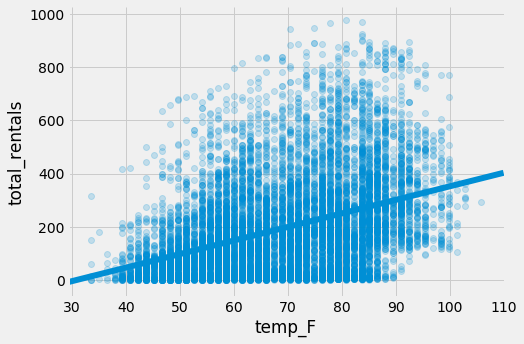

In [23]:
# Seaborn scatterplot with regression line
sns.lmplot(x='temp_F', y='total_rentals', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2});

#### Rebuild the `LinearRegression` from above using the `temp_F` features instead.

In [24]:
# Create X and y.
feature_cols = ['temp_F']
X = bikes[feature_cols]
y = bikes.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

-156.98561782129445
[5.09474471]


#### Convert 25 degrees Celsius to Fahrenheit.

In [29]:
25 * 1.8 + 32

77.0

#### Predict rentals for 77 degrees Fahrenheit.

In [30]:
linreg.predict(77)

array([ 235.309725])

**Conclusion:** The scale of the features is irrelevant for linear regression models. When changing the scale, we simply change our interpretation of the coefficients.

In [31]:
# Remove the temp_F column.
bikes.drop('temp_F', axis=1, inplace=True)

<a id="work-with-multiple-features"></a>
## Work With Multiple Features
---

We've demonstrated simple linear regression with one feature to gain an intuition, but the benefit of modeling is the ability to reason about hundreds of features at once. There is no limit to the number of features you can use. However, often a small set of features accounts for most of the variance (assuming there is a linear relationship at all). We will start by using four features.

<a id="visualizing-the-data-part-"></a>
### Visualizing the Data (Part 2)

#### Explore more features.

In [25]:
# Create feature column variables
feature_cols = ['temp', 'season', 'weather', 'humidity']

#### Create a subset of scatterplot matrix using Seaborn.
We can use pairplot with the y_vars argument to only show relationships with the `total_rentals` variable

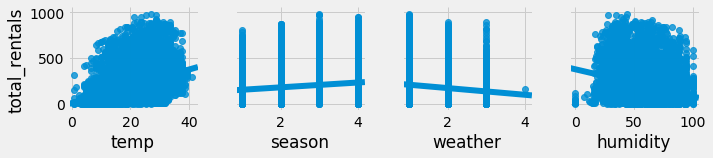

In [26]:
# multiple scatterplots in Seaborn
sns.pairplot(bikes, x_vars=feature_cols, y_vars='total_rentals', kind='reg');

#### Recreate the same functionality using Pandas.

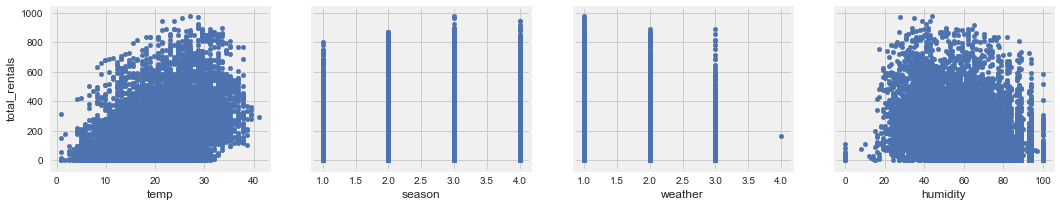

In [34]:
# Multiple scatterplots in Pandas
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    bikes.plot(kind='scatter', x=feature, y='total_rentals', ax=axs[index], figsize=(16, 3))

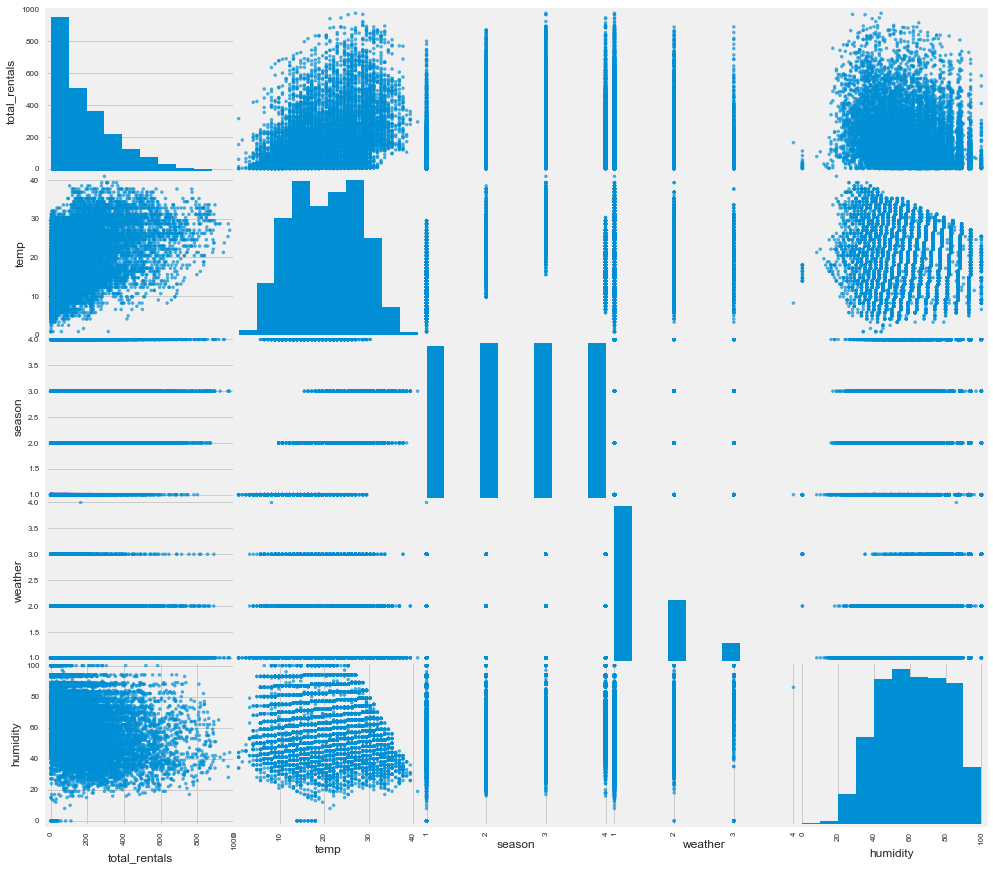

In [35]:
# alternative way in Pandas (might take a while)
# scatter_matrix does a pairplot of *every* column

grr = pd.plotting.scatter_matrix(bikes[['total_rentals'] + feature_cols], figsize=(15, 15), alpha=0.7)

#### Are you seeing anything you didn't expect?

#### Explore the season variable using a cross-tab.

In [36]:
# Cross-tabulation of season and month
pd.crosstab(bikes.season, bikes.index.month)

col_0,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,884,901,901,0,0,0,0,0,0,0,0,0
2,0,0,0,909,912,912,0,0,0,0,0,0
3,0,0,0,0,0,0,912,912,909,0,0,0
4,0,0,0,0,0,0,0,0,0,911,911,912


#### Explore the season variable using a box plot.

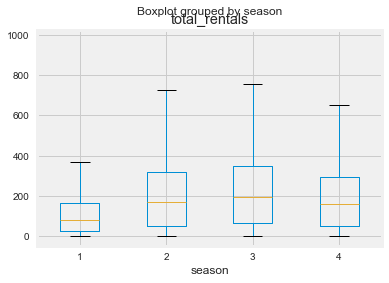

In [37]:
# Box plot of rentals, grouped by season
bikes.boxplot(column='total_rentals', by='season');

Notably:

- A line can't capture a nonlinear relationship.

#### Look at rentals over time.

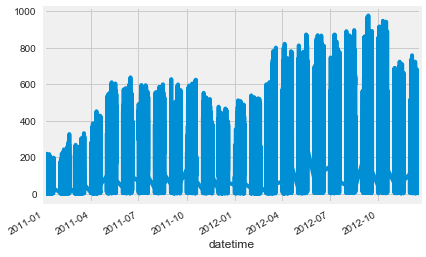

In [38]:
# Line plot of rentals
bikes.total_rentals.plot();

#### What does this tell us?

There are more rentals in the winter than the spring, but only because the system is experiencing overall growth and the winter months happen to come after the spring months.

#### Look at the correlation matrix for the bikes `DataFrame`.

In [39]:
# Correlation matrix (ranges from 1 to -1)
bikes.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


#### Use a heat map to make it easier to read the correlation matrix.

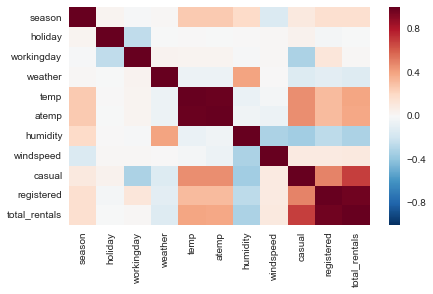

In [40]:
# Visualize correlation matrix in Seaborn using a heat map.
sns.heatmap(bikes.corr())

#### What relationships do you notice?

In [41]:
# A:

<a id="adding-more-features-to-the-model"></a>
### Adding More Features to the Model

In the previous example, one variable explained the variance of another; however, more often than not, we will need multiple variables. 

- For example, a house's price may be best measured by square feet, but a lot of other variables play a vital role: bedrooms, bathrooms, location, appliances, etc. 

- For a linear regression, we want these variables to be largely independent of one another, but all of them should help explain the y variable.

We'll work with bikeshare data to showcase what this means and to explain a concept called multicollinearity.

#### Create another `LinearRegression` instance that is fit using temp, season, weather, and humidity.

In [42]:
# Create a list of features.
feature_cols = ['temp', 'season', 'weather', 'humidity']

In [43]:
# Create X and y.
X = bikes[feature_cols]
y = bikes.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

159.520687861
[  7.86482499  22.53875753   6.67030204  -3.11887338]


#### Display the linear regression coefficient along with the feature names.

In [44]:
# Pair the feature names with the coefficients.
list(zip(feature_cols, linreg.coef_))

[('temp', 7.8648249924774394),
 ('season', 22.538757532466761),
 ('weather', 6.6703020359237186),
 ('humidity', -3.1188733823965009)]

Interpreting the coefficients:

- Holding all other features fixed, a 1-unit increase in temperature is associated with a rental increase of 7.86 bikes.
- Holding all other features fixed, a 1-unit increase in season is associated with a rental increase of 22.5 bikes.
- Holding all other features fixed, a 1-unit increase in weather is associated with a rental increase of 6.67 bikes.
- Holding all other features fixed, a 1-unit increase in humidity is associated with a rental decrease of 3.12 bikes.

Does anything look incorrect and does not reflect reality?

## Do X's significantly explain y? (i.e. do they have low P-Values).

Unfortunately the Scikit learn linear regressor doesn't have a method to calculate p-values. There are a few ways we can solve for this one:
1. Extend the linear regressor class (advanced)
2. Run analysis against our dataset independently (statsmodel.api)
3. Import another package to assist (regressors)
4. Calculate the p-values with linear algebra (essentially what we'd automate in step 1)

We could calculate these manually - but for efficiency we're going to use the statsmodels.api we imported as sm at the beginning of this notebook.

**Since we haven't updated our linear regression model we could simple see the p-values from a standards OLS model from statsmodels.api which we imported as SM**

Statsmodels is a good method to analyze your data before you put it into your model. Once you understand the significance of different variables I would build the final model using SKLearn which includes more useful features

In [45]:
X2 = sm.add_constant(X)  #Adds our y intercept
est = sm.OLS(y, X2)  # adds our OLS model
est2 = est.fit() # fits our model
print(est2.summary()) #Tada!

                            OLS Regression Results                            
Dep. Variable:          total_rentals   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     947.3
Date:                Thu, 24 May 2018   Prob (F-statistic):               0.00
Time:                        14:18:41   Log-Likelihood:                -70419.
No. Observations:               10886   AIC:                         1.408e+05
Df Residuals:                   10881   BIC:                         1.409e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        159.5207      6.931     23.016      0.0

**Another approach is to use the regressor package which will take into account our skilearn model**

Requires you to run pip install regressors

In [46]:
from regressors import stats

stats.summary(linreg, X, y, feature_cols)

Residuals:
Min        1Q    Median        3Q       Max
-64.894  126.5292  189.2629  254.8259  497.0065


Coefficients:
              Estimate  Std. Error  t value   p value
_intercept  159.520688    6.906727  23.0964  0.000000
temp          7.864825    0.148937  52.8065  0.000000
season       22.538758    1.398014  16.1220  0.000000
weather       6.670302    2.543527   2.6225  0.008742
humidity     -3.118873    0.035125 -88.7935  0.000000
---
R-squared:  0.25830,    Adjusted R-squared:  0.25802
F-statistic: 947.33 on 4 features


<a id="what-is-multicollinearity"></a>
## What Is Multicollinearity?
---

Multicollinearity happens when two or more features are highly correlated with each other. The problem is that due to the high correlation, it's hard to disambiguate which feature has what kind of effect on the outcome. In other words, the features mask each other. 

There is a second related issue called variance inflation where including correlated features increases the variability of our model and p-values by widening the standard errors. This can be measured with the variance inflation factor, which we will not cover here.

#### With the bikeshare data, let's compare three data points: actual temperature, "feel" temperature, and guest ridership.

            temp     atemp    casual
temp    1.000000  0.984948  0.467097
atemp   0.984948  1.000000  0.462067
casual  0.467097  0.462067  1.000000
Axes(0.08,0.125;0.696x0.755)


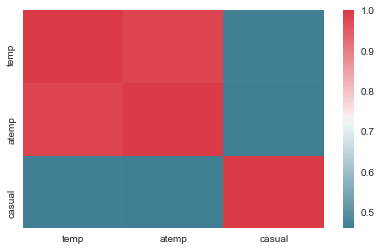

In [47]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
correlations = bikes[['temp', 'atemp', 'casual']].corr()
print(correlations)
print(sns.heatmap(correlations, cmap=cmap))

#### Create a linear model that predicts `total_rentals` using `temp` and `atemp`.

In [29]:
# Create a list of features.
feature_cols = ['atemp', 'temp']

In [30]:
# Create X and y.
X = bikes[feature_cols]
y = bikes.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(list(zip(feature_cols,linreg.coef_)))

4.248132645803878
[('atemp', 0.9072080844659027), ('temp', 8.198658744678792)]


#### Go back and remove either `temp` or `atemp` from the feature list. How do the coefficients change? 

In [50]:
# A:

<a id="how-to-select-a-model"></a>
## How to Select a Model
---

We can make linear models now, but how do we select the best model to use for our applications? We will offer a general procedure and a simple metric that works well in many cases. That said, it's important to keep the business context in mind and know that there are alternative metrics that can work better.

<a id="feature-selection"></a>
### Feature Selection

How do we choose which features to include in the model? We're going to use **train/test split** (and eventually **cross-validation**).

Why not use p-values or R-squared for feature selection?

- Linear models rely upon a lot of assumptions (such as the features being independent), and if those assumptions are violated, p-values and R-squared are less reliable. Train/test split relies on fewer assumptions.
- If all of the assumptions of a linear model are met, p-values suggest a coefficient that differs from zero at a level of statistical significance. This does not mean that
    1. the feature _causes_ the response
    2. the feature strongly _predicts_ the response. 
- Adding features to your model that are unrelated to the response will always increase the R-squared value, and adjusted R-squared does not sufficiently account for this (although, AIC and BIC do).
- p-values and R-squared are **proxies** for our goal of generalization, whereas train/test split and cross-validation attempt to directly estimate how well the model will generalize to out-of-sample data.

More generally:

- There are different methodologies that can be used for solving any given data science problem, and this course follows a machine learning methodology.
- This course focuses on general purpose approaches that can be applied to any model, rather than model-specific approaches.

<a id="evaluation-metrics-for-regression-problems"></a>
### Evaluation Metrics for Regression Problems

Evaluation metrics for classification problems, such as accuracy, are not useful for regression problems. We need evaluation metrics designed for comparing continuous values.

Here are three common evaluation metrics for regression problems:

**Mean absolute error (MAE)** is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean squared error (MSE)** is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root mean squared error (RMSE)** is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [51]:
# Example true and predicted response values
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]

#### Calculate MAE, MSE, and RMSE using imports from sklearn metrics and NumPy.

In [52]:
# Calculate these metrics by hand!
from sklearn import metrics
import numpy as np
print('MAE:', metrics.mean_absolute_error(true, pred))
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 2.0
MSE: 7.5
RMSE: 2.73861278753


Let's compare these metrics:

- MAE is the easiest to understand, because it's the average error.
- MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world. Also, MSE is continuous and differentiable, making it easier to use than MAE for optimization.
- RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

Here's an additional example, to demonstrate how MSE/RMSE punishes larger errors:

In [53]:
# Same true values as above
true = [10, 7, 5, 5]

# New set of predicted values
pred = [10, 7, 5, 13]

# MAE is the same as before.
print('MAE:', metrics.mean_absolute_error(true, pred))

# MSE and RMSE are larger than before.
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 2.0
MSE: 16.0
RMSE: 4.0


<a id="comparing-models-with-traintest-split-and-rmse"></a>
### Comparing Models With Train/Test Split and RMSE

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [ ]:
# Before splitting
print(X.shape)

# After splitting
print(X_train.shape)
print(X_test.shape)

#### Understanding the `random_state` Parameter

The `random_state` is a pseudo-random number that allows us to reproduce our results every time we run them. However, it makes it impossible to predict what are exact results will be if we chose a new `random_state`.

`random_state` is very useful for testing that your model was made correctly since it provides you with the same split each time. However, make sure you remove it if you are testing for model variability!

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


In [54]:
from sklearn.model_selection import train_test_split

# Define a function that accepts a list of features and returns testing RMSE.
def train_test_rmse(df, feature_cols, response):
    X = df[feature_cols]
    y = df[response]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [55]:
# Compare different sets of features.
print(train_test_rmse(bikes, ['temp', 'season', 'weather', 'humidity'], 'total_rentals'))
print(train_test_rmse(bikes, ['temp', 'season', 'weather'],'total_rentals'))
print(train_test_rmse(bikes, ['temp', 'season', 'humidity'],'total_rentals'))

155.649459131
164.165399763
155.598189367


In [56]:
# Using these as features is not allowed!
print(train_test_rmse(bikes, ['casual', 'registered'],'total_rentals'))

6.46507997608e-14


<a id="comparing-testing-rmse-with-null-rmse"></a>
### Comparing Testing RMSE With Null RMSE

Null RMSE is the RMSE that could be achieved by always predicting the mean response value. It is a benchmark against which you may want to measure your regression model.

In [57]:
# Split X and y into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Create a NumPy array with the same shape as y_test.
y_null = np.zeros_like(y_test, dtype=float)

# Fill the array with the mean value of y_test.
y_null.fill(y_test.mean())
y_null

array([ 192.26451139,  192.26451139,  192.26451139, ...,  192.26451139,
        192.26451139,  192.26451139])

In [58]:
# Compute null RMSE.
np.sqrt(metrics.mean_squared_error(y_test, y_null))

179.57906896465727

### Comparing Test Performance With a Null Baseline

When interpreting the predictive power of a model, it's best to compare it to a baseline using a dummy model, sometimes called a ZeroR model or a baseline model. 

- A dummy model is simply using the mean, median, or most common value as the prediction. This forms a benchmark to compare your model against and becomes especially important in classification where your null accuracy might be 95 percent.
<br>
<br>
- For example, suppose your dataset is **imbalanced** -- it contains 99% one class and 1% the other class. Then, your baseline accuracy (always guessing the first class) would be 99%. So, if your model is less than 99% accurate, you know it is worse than the baseline. Imbalanced datasets generally must be trained differently (with less of a focus on accuracy) because of this.
<br>
<br>
- You can alternatively use simple models to achieve baseline results, for example nearest neighbors or a basic unigram bag of words for text data.

<a id="feature-engineering-to-improve-performance"></a>
## Feature Engineering to Improve Performance
---

Machine learning models are very powerful, but they cannot automatically handle every aspect of our data. We have to explicitly modify our features to have relationships that our models can understand. In this case, we will need to pull out features to have a linear relationship with our response variable.


<a id="handling-categorical-features"></a>
### Handling Categorical Features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** Transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** Use dummy encoding (0/1). Here, each possible category would become a separate feature.

What are the categorical features in our data set?

- **Ordered categories:** `weather` (already encoded with sensible numeric values)
- **Unordered categories:** `season` (needs dummy encoding), `holiday` (already dummy encoded), `workingday` (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an ordered relationship. Instead, we create multiple dummy variables.

#### Create dummy variables using `get_dummies` from Pandas.

In [59]:
season_dummies = pd.get_dummies(bikes.season, prefix='season')

#### Inspect the `DataFrame` of `dummies`.

In [60]:
# Print five random rows.
season_dummies.sample(n=5, random_state=1)

,season_1,season_2,season_3,season_4
datetime,,,,
2011-09-05 11:00:00,0,0,1,0
2012-03-18 04:00:00,1,0,0,0
2012-10-14 17:00:00,0,0,0,1
2011-04-04 15:00:00,0,1,0,0
2012-12-11 02:00:00,0,0,0,1


However, we actually only need three dummy variables (not four), and thus we'll drop the first dummy variable.

Why? Because three dummies captures all of the "information" about the season feature, and implicitly defines spring (season 1) as the baseline level.

This circles back to the concept multicollinearity, except instead of one feature being highly correlated to another, the information gained from three features is directly correlated to the fourth.

#### Drop the first column.

In [61]:
season_dummies.drop(season_dummies.columns[0], axis=1, inplace=True)

#### Reinspect the `DataFrame` of `dummies`.

In [62]:
# Print five random rows.
season_dummies.sample(n=5, random_state=1)

,season_2,season_3,season_4
datetime,,,
2011-09-05 11:00:00,0,1,0
2012-03-18 04:00:00,0,0,0
2012-10-14 17:00:00,0,0,1
2011-04-04 15:00:00,1,0,0
2012-12-11 02:00:00,0,0,1


In general, if you have a categorical feature with k possible values, you create k-1 dummy variables.

If that's confusing, think about why we only need one dummy variable for `holiday`, not two dummy variables (`holiday_yes` and `holiday_no`).

#### We now need to concatenate the two `DataFrames` together.

In [63]:
# Concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns).
bikes_dummies = pd.concat([bikes, season_dummies], axis=1)

# Print 5 random rows.
bikes_dummies.sample(n=5, random_state=1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,
2011-09-05 11:00:00,3,1,0,2,28.70,33.335,74,11.0014,101,207,308,0,1,0
2012-03-18 04:00:00,1,0,0,2,17.22,21.210,94,11.0014,6,8,14,0,0,0
2012-10-14 17:00:00,4,0,0,1,26.24,31.060,44,12.9980,193,346,539,0,0,1
2011-04-04 15:00:00,2,0,1,1,31.16,33.335,23,36.9974,47,96,143,1,0,0
2012-12-11 02:00:00,4,0,1,2,16.40,20.455,66,22.0028,0,1,1,0,0,1


#### Rerun the linear regression with dummy variables included.

In [64]:
# Include dummy variables for season in the model.
feature_cols = ['temp', 'season_2', 'season_3', 'season_4', 'humidity']
X = bikes_dummies[feature_cols]
y = bikes_dummies.total_rentals

linreg = LinearRegression()
linreg.fit(X, y)

list(zip(feature_cols, linreg.coef_))

[('temp', 11.186405863575784),
 ('season_2', -3.3905430997179598),
 ('season_3', -41.736860713170678),
 ('season_4', 64.415961468242145),
 ('humidity', -2.819481636259646)]

How do we interpret the season coefficients? They are measured against the baseline (spring):

- Holding all other features fixed, summer is associated with a rental decrease of 3.39 bikes compared to the spring.
- Holding all other features fixed, fall is associated with a rental decrease of 41.7 bikes compared to the spring.
- Holding all other features fixed, winter is associated with a rental increase of 64.4 bikes compared to the spring.

Would it matter if we changed which season was defined as the baseline?

- No, it would simply change our interpretation of the coefficients.

In most situations, it is best to have the dummy that is your baseline be the category that has the largest representation.

**Important:** Dummy encoding is relevant for all machine learning models, not just linear regression models.

In [65]:
# Compare original season variable with dummy variables.
print(train_test_rmse(bikes_dummies, ['temp', 'season', 'humidity'],'total_rentals'))
print(train_test_rmse(bikes_dummies, ['temp', 'season_2', 'season_3', 'season_4', 'humidity'],'total_rentals'))

155.598189367
154.333945936


#### Let's dig a little deeper with the help of visuals and statistics

In [66]:
# First let's build a function to do some of the work for us. When do we want to build functions?

from sklearn import feature_selection, linear_model

def get_linear_model_metrics(X, y, algo):
    # get the pvalue of X given y. Ignore f-stat for now.
    pvals = feature_selection.f_regression(X, y)[1]
    # start with an empty linear regression object
    # .fit() runs the linear regression function on X and y
    algo.fit(X,y)
    residuals = (y-algo.predict(X)).values

    # print the necessary values
    print('P Values:', pvals)
    print('Coefficients:', algo.coef_)
    print('y-intercept:', algo.intercept_)
    print('R-Squared:', algo.score(X,y))
    plt.figure()
    plt.hist(residuals, bins=int(np.ceil(np.sqrt(len(y)))))
    # keep the model
    return algo

### Run through the following code on your own.
#### What happens to the coefficients when you include all weather situations instead of just including all except one?

P Values: [  3.40875525e-28   1.60734052e-05   8.76435172e-35   8.79014707e-01]
Coefficients: [  5.02796131e+14   5.02796131e+14   5.02796131e+14   5.02796131e+14]
y-intercept: -5.02796130878e+14
R-Squared: 0.0177006272292
P Values: [  3.40875525e-28   1.60734052e-05   8.76435172e-35]
Coefficients: [ 41.23679088  14.95553987 -45.15366705]
y-intercept: 164.0
R-Squared: 0.0177451020886


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

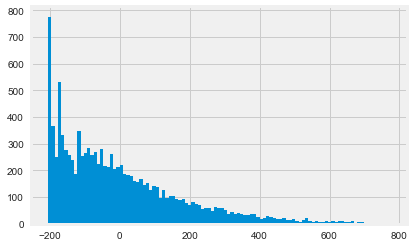

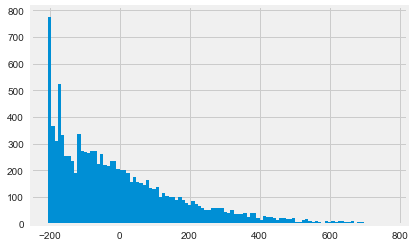

In [67]:
lm = linear_model.LinearRegression()
weather = pd.get_dummies(bikes.weather)

get_linear_model_metrics(weather[[1, 2, 3, 4]], y, lm)
# drop the least significant, weather situation  = 4
get_linear_model_metrics(weather[[1, 2, 3]], y, lm)

### Interpretation: 
This model makes more sense, because we can more easily explain the variables compared to the one we left out. 

For example, this suggests that a clear day (weathersit:1) on average brings in about 38 more riders hourly than a day with heavy snow. 

In fact, since the weather situations "degrade" in quality (1 is the nicest day, 4 is the worst), the coefficients now reflect that well. 

However at this point, there is still a lot of work to do, because weather on its own fails to explain ridership well.




In [68]:
bikes.dtypes

season             int64
holiday            int64
workingday         int64
weather            int64
temp             float64
atemp            float64
humidity           int64
windspeed        float64
casual             int64
registered         int64
total_rentals      int64
dtype: object

<a id="feature-engineering"></a>
### Feature Engineering

See if you can create the following features:

- **hour:** as a single numeric feature (0 through 23)
- **hour:** as a categorical feature (use 23 dummy variables)
- **daytime:** as a single categorical feature (daytime=1 from 7 a.m. to 8 p.m., and daytime=0 otherwise)

Then, try using each of the three features (on its own) with `train_test_rmse` to see which one performs the best!

#### Extract hour of the day to use as a feature.

#### Encode `hour` as a categorical feature.

In [69]:
# Tip - this means getting dummies

#### Generate a `daytime` variable based on hour of the day.

In [70]:
# Tip - use conditions to set a value that identifies day vs night (think sunrise to sunset?)

#### Test the root mean squared error of our various `hour` encodings.

In [71]:
# Remember we built the function train_test_rmse()


## Independent Practice: Building models

### First Model - Look at the TV, Radio and Newspaper data we reviewed for visualizations


In [72]:
# Read in the data
Media = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)
Media.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [73]:
# Use sns.lmplot() to explore distributions



In [74]:
# Create a correlation matrix &/or heatmap to check for collinearity



In [75]:
# Fit a linear model & print summary


#### 1. Which of the media buys were significantly associated with the sales? 

#### 2. Controlling for all the other media buys, which media type had the largest association with sales?

#### 3. Given that one of the variables above was not significant do we drop it from our model? Why or why not? 

### Second Model with Bike Share: Building models for other y variables

We've completely a model together that explains total rides. Now it's your turn to build another model, using a different y variable: registered riders.

#### Pay attention to:

* the distribution of riders (should we rescale the data?)  
* checking correlations with variables and registered riders  
* having a feature space (our matrix) with low multicollinearity  
* model complexity vs explanation of variance: at what point do features in a model stop improving r-squared?  
* the linear assumption -- given all feature values being 0, should we have no ridership? negative ridership? positive ridership?

#### Bonus

* Which variables would make sense to dummy (because they are categorical, not continuous)?  
* What features might explain ridership but aren't included in the data set? 
* Is there a way to build these using pandas and the features available?
* Outcomes If your model at least improves upon the original model and the explanatory effects (coefficients) make sense, consider this a complete task. 


In [76]:
bikes.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'total_rentals'],
      dtype='object')

### Third Model - Looking at Wine
- Partner up and use the 'wine' Dataset to perform a linear regression between wine quality and its characteristics
- Use the documentation/data dictionary if you need clarification: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

In [77]:
drinks = pd.read_csv('data/wine.csv')
drinks.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [78]:
# Create a correlation matrix.



In [ ]:
# Select three to five features to use to predict quality

best_cols = 



In [ ]:
# Setup a train test split
train_x = 
train_y = drinks['quality']

test_x = 
test_y = drinks['quality']

In [ ]:
# Instantiate, fit and predict using a Linear Regressor



In [ ]:
# Calculate the RMSE



In [ ]:
# Calculate the R-Squared value



In [ ]:
# Calculate the baseline by using just the average quality - Did you see an improvement in RSME?



<a id="bonus-material-regularization"></a>
## Bonus Material: Regularization
---

- Regularization is a method for "constraining" or "regularizing" the size of the coefficients, thus "shrinking" them toward zero.
- It reduces model variance and thus minimizes overfitting.
- If the model is too complex, it tends to reduce variance more than it increases bias, resulting in a model that is more likely to generalize.

Our goal is to locate the optimum model complexity, and thus regularization is useful when we believe our model is too complex.

<a id="how-does-regularization-work"></a>
### How Does Regularization Work?

For a normal linear regression model, we estimate the coefficients using the least squares criterion, which minimizes the residual sum of squares (RSS).

For a regularized linear regression model, we minimize the sum of RSS and a "penalty term" that penalizes coefficient size.

**Ridge regression** (or "L2 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p \beta_j^2$$

**Lasso regression** (or "L1 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p |\beta_j|$$

- $p$ is the number of features.
- $\beta_j$ is a model coefficient.
- $\alpha$ is a tuning parameter:
    - A tiny $\alpha$ imposes no penalty on the coefficient size, and is equivalent to a normal linear regression model.
    - Increasing the $\alpha$ penalizes the coefficients and thus shrinks them.

<a id="lasso-and-ridge-path-diagrams"></a>
### Lasso and Ridge Path Diagrams

A larger alpha (toward the left of each diagram) results in more regularization:

- Lasso regression shrinks coefficients all the way to zero, thus removing them from the model.
- Ridge regression shrinks coefficients toward zero, but they rarely reach zero.

Source code for the diagrams: [Lasso regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html) and [Ridge regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html)

![Lasso and Ridge Coefficient Plots](./assets/lasso_ridge_path.png)

<a id="advice-for-applying-regularization"></a>
### Advice for Applying Regularization

**Should features be standardized?**

- Yes, because otherwise, features would be penalized simply because of their scale.
- Also, standardizing avoids penalizing the intercept, which wouldn't make intuitive sense.

**How should you choose between lasso regression and ridge regression?**

- Lasso regression is preferred if we believe many features are irrelevant or if we prefer a sparse model.
- Ridge can work particularly well if there is a high degree of multicollinearity in your model.
- If model performance is your primary concern, it is best to try both.
- Elastic net regression is a combination of lasso regression and ridge Regression.

<a id="ridge-regression"></a>
### Ridge Regression

- [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) documentation
- **alpha:** must be positive, increase for more regularization
- **normalize:** scales the features (without using StandardScaler)

In [ ]:
# Include dummy variables for season in the model.
feature_cols = ['temp', 'atemp', 'season_2', 'season_3', 'season_4', 'humidity']

X = bikes_dummies[feature_cols]
y = bikes_dummies.total_rentals

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# alpha=0 is equivalent to linear regression.
from sklearn.linear_model import Ridge

# Instantiate the model.
#(Alpha of zero has no regularization strength, essentially a basic linear regression.)
ridgereg = Ridge(alpha=0, normalize=True)

# Fit the model.
ridgereg.fit(X_train, y_train)

# Predict with fitted model.
y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
# Coefficients for a non-regularized linear regression
list(zip(feature_cols, ridgereg.coef_))

To interpret these coefficients we need to convert them back to original units, which is a reason to do normalization by hand. However, in this form the coefficients have a special meaning. The intercept is now the average of our outcome, and the magnitude of each coefficient in the model is a measure of how important it is in the model. We call this feature importance.

In [ ]:
# Try alpha=0.1.
ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
# Examine the coefficients.
list(zip(feature_cols, ridgereg.coef_))

While the MSE barely changed, we can see there are significant changes in the weight of our coefficients.  Particularly `season_2` whose coefficient has greatly decreased toward 0.

Fitting and using a Lasso Regression in scikit-learn is very similar.  

In addition to the typical [lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) and [ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) there is a third type of regression, [Elastic Net](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) which combines the penalties of the ridge and lasso methods.

<a id="comparing-linear-regression-with-other-models"></a>
## Comparing Linear Regression With Other Models

Advantages of linear regression:

- Simple to explain.
- Highly interpretable.
- Model training and prediction are fast.
- No tuning is required (excluding regularization).
- Features don't need scaling.
- Can perform well with a small number of observations.
- Well understood.

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response.
- Performance is (generally) not competitive with the best supervised learning methods due to high bias.
- Can't automatically learn feature interactions.